In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
from neural_network import NeuralNetwork
from noise_utils import salt_pepper_noise, random_noise, gaussian_noise

# Exercise 3

### Question A

In [3]:
x = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

In [4]:
df = pd.DataFrame(np.concatenate((x, y), axis=1), columns=('x1', 'x2', 'y'))
df.style.hide()

x1,x2,y
0,0,0
0,1,1
1,0,1
1,1,0


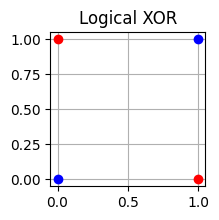

In [5]:
plt.figure(figsize=(2,2))

plt.plot(*x[0], 'o', color='blue')
plt.plot(*x[1], 'o', color='red')
plt.plot(*x[2], 'o', color='red')
plt.plot(*x[3], 'o', color='blue')
plt.grid()
plt.title('Logical XOR')

plt.show()

In [6]:
learning_rate = 0.1
epochs = 10000
nn_A = NeuralNetwork([2, 2, 1], activation_function='sigmoid')
nn_A.train(x, y, learning_rate, epochs, verbose=True)
nn_A.predict(x)

array([[0],
       [1],
       [1],
       [0]])

### Question B

Load raw data

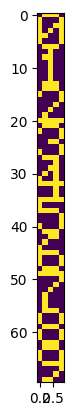

In [7]:
data = np.loadtxt("TP3-ej3-digitos.txt", dtype=np.uint8) 
plt.imshow(data);

Flatten data

In [8]:
data_flattened = data.flatten()
data_flattened = np.reshape(data_flattened, (10, 35))

print(data_flattened.shape)
data_flattened

(10, 35)


array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 1

Initialize x input (flattened digit) and y output (result of whether digit is pair)

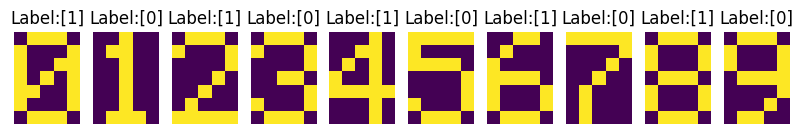

In [9]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [10]:
learning_rate = 0.1
epochs = 10000

nn_B = NeuralNetwork([35, 10, 1])
nn_B.train(x, y, learning_rate, epochs, verbose=True)
nn_B.predict(x)

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

digit is even: [[0]]


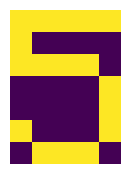

In [11]:
digit = 5

plt.figure(figsize=(2,2))
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
plt.axis('off')
res = nn_B.predict(data_flattened[digit])
print('digit is even:', res)

### Exercise C

Initialize data
- x: 10*35 (10 digits * 35 pixels each)
- y: 10*1 (can be classified to 10 possible digits)

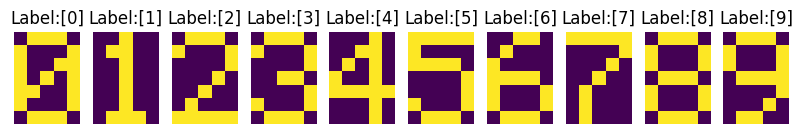

In [12]:
x = data_flattened
y = np.arange(10).reshape(-1, 1)

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [13]:
input_size = 35
hidden_size = 10
output_size = 10

learning_rate = 0.1
epochs = 100000

nn_C = NeuralNetwork([35, 10, 10], one_hot=True, activation_function='sigmoid')
nn_C.train(x, y, learning_rate, epochs, verbose=True)
nn_C.predict(x)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

digit is: [[7]]


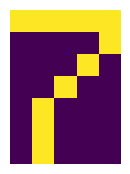

In [14]:
digit = 7

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
res = nn_C.predict(data_flattened[digit])
print('digit is:', res)

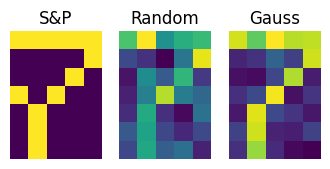

In [15]:
salt_pepper_digit = salt_pepper_noise(data_flattened[digit], 0.05, 0.05)
random_digit = random_noise(data_flattened[digit])
gauss_digit = gaussian_noise(data_flattened[digit], 0.1, 0.1)

noised_data = [salt_pepper_digit, random_digit, gauss_digit]
titles = ['S&P', 'Random', 'Gauss']

plt.figure(figsize=(4,3))
for i, img in enumerate(noised_data):
    plt.subplot(1, 3, i+1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)));

In [16]:
nn_C.predict(salt_pepper_digit)

array([[7]])

# Analysis / graphs

## 3a

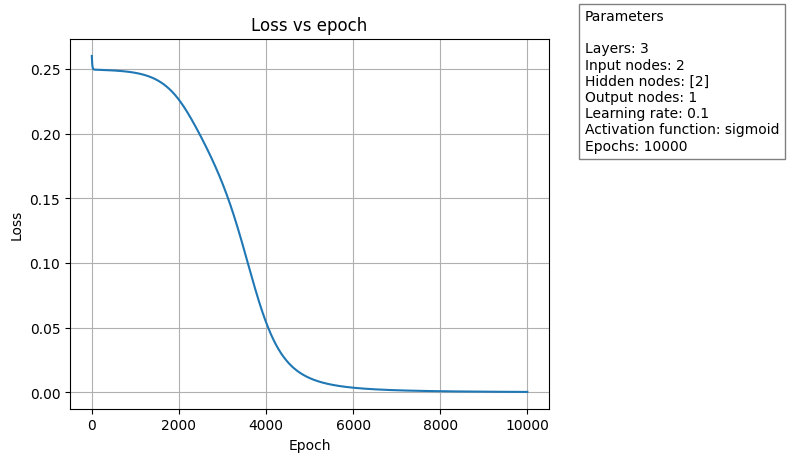

In [17]:
nn_A.graph('loss')

## 3b

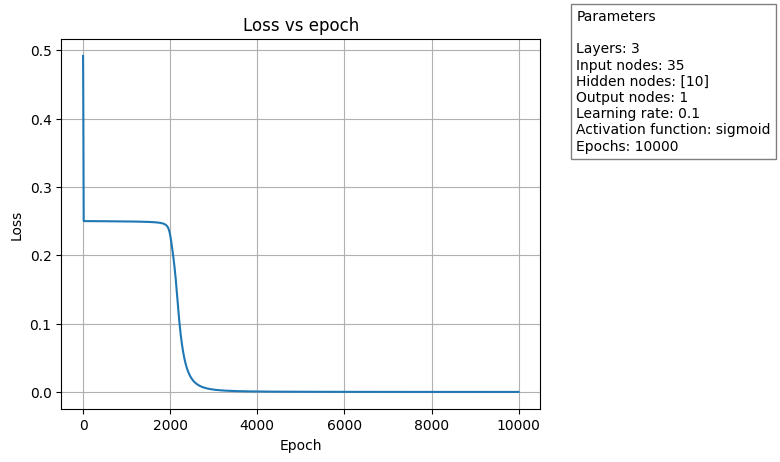

In [18]:
nn_B.graph(graph_type='loss')

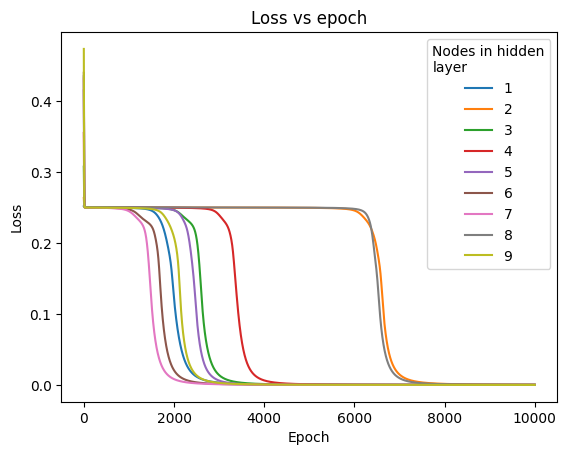

In [19]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)
learning_rate = 0.1
epochs = 10000

losses = []

for i in np.arange(1, 10):
    nn_B = NeuralNetwork([35, i, 1])
    nn_B.train(x, y, learning_rate, epochs)
    plt.plot(nn_B.losses)
plt.legend(np.arange(1, 10), title='Nodes in hidden\nlayer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss vs epoch')
plt.show()

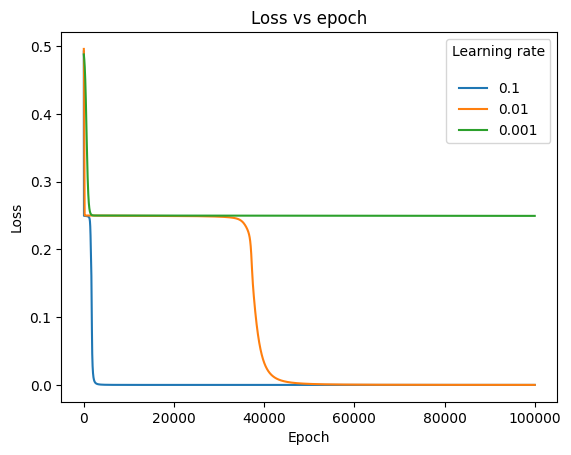

In [20]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)
learning_rates = [0.1, 0.01, 0.001]
epochs = 100000

losses = []

for learning_rate in learning_rates:
    nn_B = NeuralNetwork([35, i, 1])
    nn_B.train(x, y, learning_rate, epochs)
    plt.plot(nn_B.losses)
plt.legend(learning_rates, title='Learning rate\n')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss vs epoch')
plt.show()

## 3c

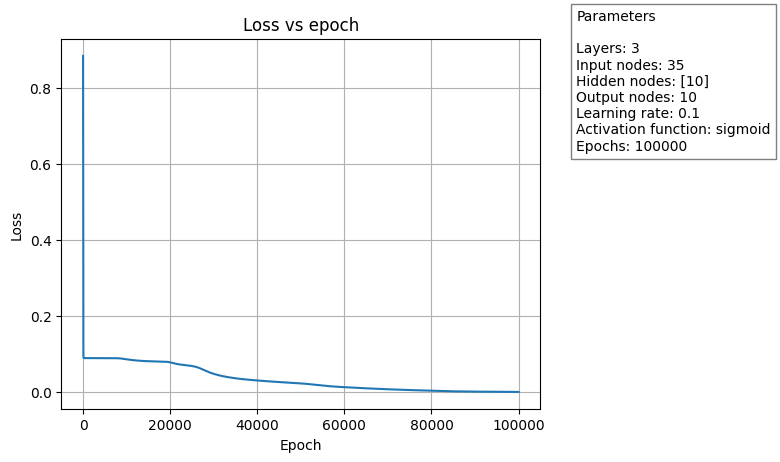

In [21]:
nn_C.graph('loss')

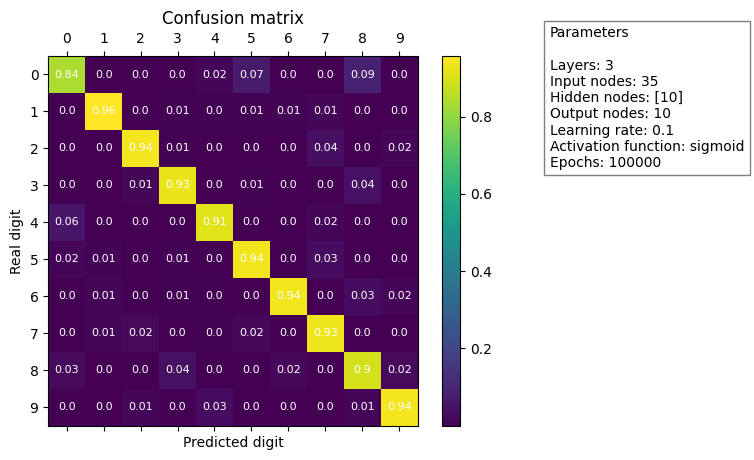

In [22]:
nn_C.graph(graph_type='confusion')

## Train test

In [27]:
def generate_test_dataset(num_values, data_source):
    dataX = []
    dataY = []
    
    for i in range(num_values):
        value = np.random.randint(10)
        dataX.append([data_flattened[value]])
        dataY.append(value)

    return np.array(dataX).squeeze(), np.array(dataY)

def train_test(dataX, dataY, num_values, percentage):
    split = round(num_values*percentage)
    
    dataX_train = dataX[:split]
    dataY_train = dataY[:split]
    dataX_test = dataX[split:]
    dataY_test = dataY[split:]
    
    return dataX_train, dataY_train, dataX_test, dataY_test

In [28]:
num_values = 30
dataX, dataY = generate_test_dataset(30, data_flattened)
dataX_train, dataY_train, dataX_test, dataY_test = train_test(dataX, dataY, num_values, 0.75)

In [53]:
input_size = 35
hidden_size = 10
output_size = 10

learning_rate = 0.1
epochs = 10000

nn_C = NeuralNetwork([35, 10, 10], one_hot=True, activation_function='sigmoid')
nn_C.train(dataX_train, dataY_train, learning_rate, epochs)

ValueError: operands could not be broadcast together with shapes (22,10) (10,22) 

In [56]:
dataY_train

array([2, 4, 4, 8, 2, 6, 2, 2, 5, 6, 7, 6, 0, 2, 9, 8, 9, 2, 3, 4, 6, 9])

In [55]:
dataY_train.reshape(-1, 1).shape

(22, 1)